In [ ]:
#pharma BI project

In [1]:
# Libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from statsmodels.tsa.statespace.sarimax import SARIMAX
import shap
import joblib
import os

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Database Connection
DB_PATH =  r"C:\\Users\\HP\\Desktop\\_Multi-faced_BI_Pharma_project\\project\\db\\pharma.db"
conn = sqlite3.connect(DB_PATH)

In [4]:
patients = pd.read_sql("SELECT * FROM patients", conn)
labs = pd.read_sql("SELECT * FROM labs", conn)
prescriptions = pd.read_sql("SELECT * FROM prescriptions", conn)
sales = pd.read_sql("SELECT * FROM sales_monthly", conn)
ae_reports = pd.read_sql("SELECT * FROM ae_reports", conn)
print("Data loaded from database.")

Data loaded from database.


In [5]:
# previewing datasets
print("--- Patients ---")
display(patients.head())
print("--- Labs ---")
display(labs.head())
print("--- Prescriptions ---")
display(prescriptions.head())
print("--- Sales ---")
display(sales.head())
print("--- AE Reports ---")
display(ae_reports.head())

--- Patients ---


,patient_id,age,sex,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease
0,100000,61,M,22.3,0,126,273,0,0,0
1,100001,53,M,24.3,0,92,220,0,0,0
2,100002,63,M,25.6,0,110,246,0,1,0
3,100003,73,M,32.3,0,117,244,0,1,0
4,100004,52,M,21.2,0,146,120,0,1,0


--- Labs ---


,lab_id,patient_id,lab_date,ldl,hdl,hba1c
0,1,100000,2024-12-29,168.8,49.0,5.0
1,2,100000,2025-05-05,181.6,59.0,4.9
2,3,100001,2023-05-12,145.4,61.5,6.5
3,4,100002,2023-09-27,137.1,47.5,5.6
4,5,100003,2022-08-23,156.7,61.2,6.0


--- Prescriptions ---


,rx_id,patient_id,rx_date,drug,dose_mg,therapeutic_area,drug_class
0,1,100000,2022-07-10,ALBURX,10,IMM,vaccine
1,2,100001,2024-05-30,ATORVASTATIN,40,CV,statin
2,3,100002,2024-08-05,SIMVASTATIN,20,CV,statin
3,4,100002,2024-09-26,SIMVASTATIN,10,CV,statin
4,5,100002,2022-09-04,ALBURX,10,IMM,vaccine


--- Sales ---


,id,drug,month,units,unit_price,revenue
0,1,ATORVASTATIN,2021-01-01,12421,0.6,7452.6
1,2,ATORVASTATIN,2021-02-01,11385,0.6,6831.0
2,3,ATORVASTATIN,2021-03-01,12816,0.6,7689.6
3,4,ATORVASTATIN,2021-04-01,12033,0.6,7219.8
4,5,ATORVASTATIN,2021-05-01,13891,0.6,8334.6


--- AE Reports ---


,report_id,text,label
0,1,anaphylaxis | shortness of breath,serious
1,2,fatigue,nonserious
2,3,shortness of breath,serious
3,4,arrhythmia,serious
4,5,headache,nonserious


In [6]:
#  Dataset Shapes
print("\n--- Patient Data Shape ---", patients.shape)
print("\n--- Labs Data Shape ---", labs.shape)
print("\n--- Prescriptions Data Shape ---", prescriptions.shape)
print("\n--- Sales Data Shape ---", sales.shape)
print("\n--- AE Reports Data Shape ---", ae_reports.shape)


--- Patient Data Shape --- (5000, 10)

--- Labs Data Shape --- (10011, 6)

--- Prescriptions Data Shape --- (7536, 7)

--- Sales Data Shape --- (165, 6)

--- AE Reports Data Shape --- (2000, 3)


In [7]:
# Dataset Info
print("\n--- Patient Data Info ---")
patients.info()
print("\n--- Labs Data Info ---")
labs.info()
print("\n--- Prescriptions Data Info ---")
prescriptions.info()
print("\n--- Sales Data Info ---")
sales.info()
print("\n--- AE Reports Data Info ---")
ae_reports.info()


--- Patient Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     5000 non-null   int64  
 1   age            5000 non-null   int64  
 2   sex            5000 non-null   object 
 3   bmi            5000 non-null   float64
 4   smoker         5000 non-null   int64  
 5   bp_sys         5000 non-null   int64  
 6   cholesterol    5000 non-null   int64  
 7   diabetes       5000 non-null   int64  
 8   statin_use     5000 non-null   int64  
 9   heart_disease  5000 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 390.8+ KB

--- Labs Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10011 entries, 0 to 10010
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lab_id      10011 non-null  int64  
 1   patient_id  10

In [8]:
# Summary statistics 
print("\n--- Patient Data Summary ---")
display(patients.describe())
print("\n--- Labs Data Summary ---")
display(labs.describe())
print("\n--- Prescriptions Data Summary ---")
display(prescriptions.describe())
print("\n--- Sales Data Summary ---")
display(sales.describe())
print("\n--- AE Reports Data Summary ---")
display(ae_reports.describe())


--- Patient Data Summary ---


,patient_id,age,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,102499.500000,55.054800,27.031860,0.260200,129.864000,210.414800,0.182600,0.347000,0.028800
std,1443.520003,11.929772,4.909778,0.438787,14.940822,43.425765,0.386377,0.476063,0.167261
min,100000.000000,18.000000,15.000000,0.000000,90.000000,120.000000,0.000000,0.000000,0.000000
25%,101249.750000,47.000000,23.700000,0.000000,120.000000,179.000000,0.000000,0.000000,0.000000
50%,102499.500000,55.000000,27.000000,0.000000,130.000000,210.000000,0.000000,0.000000,0.000000
75%,103749.250000,63.000000,30.300000,1.000000,140.000000,240.000000,0.000000,1.000000,0.000000
max,104999.000000,90.000000,44.100000,1.000000,189.000000,355.000000,1.000000,1.000000,1.000000



--- Labs Data Summary ---


,lab_id,patient_id,ldl,hdl,hba1c
count,10011.000000,10011.000000,10011.000000,10011.000000,10011.000000
mean,5006.000000,102500.179602,137.104665,52.802477,5.627260
std,2890.071106,1438.485289,31.871921,8.540936,0.736084
min,1.000000,100000.000000,50.000000,20.000000,4.500000
25%,2503.500000,101251.500000,115.300000,47.000000,5.100000
50%,5006.000000,102504.000000,136.800000,52.700000,5.500000
75%,7508.500000,103726.000000,158.600000,58.500000,6.100000
max,10011.000000,104999.000000,253.200000,83.700000,8.600000



--- Prescriptions Data Summary ---


,rx_id,patient_id,dose_mg
count,7536.000000,7536.000000,7536.000000
mean,3768.500000,102509.697585,37.870223
std,2175.600147,1447.760361,27.058189
min,1.000000,100000.000000,10.000000
25%,1884.750000,101258.000000,20.000000
50%,3768.500000,102491.500000,40.000000
75%,5652.250000,103772.250000,80.000000
max,7536.000000,104999.000000,80.000000



--- Sales Data Summary ---


,id,units,unit_price,revenue
count,165.000000,165.000000,165.000000,165.000000
mean,83.000000,12274.939394,3.333333,25185.801212
std,47.775517,4206.242318,4.019970,25920.868413
min,1.000000,4679.000000,0.400000,5410.800000
25%,42.000000,7825.000000,0.400000,6840.000000
50%,83.000000,13604.000000,0.600000,8186.400000
75%,124.000000,15947.000000,9.000000,51732.000000
max,165.000000,18603.000000,9.000000,82233.000000



--- AE Reports Data Summary ---


,report_id
count,2000.000000
mean,1000.500000
std,577.494589
min,1.000000
25%,500.750000
50%,1000.500000
75%,1500.250000
max,2000.000000


In [9]:
#checking for missing values
print("\n--- Missing Values ---")
print("Patients:\n", patients.isnull().sum())
print("\nLabs:\n", labs.isnull().sum())
print("\nPrescriptions:\n", prescriptions.isnull().sum())
print("\nSales:\n", sales.isnull().sum())
print("\nAE Reports:\n", ae_reports.isnull().sum())


--- Missing Values ---
Patients:
 patient_id       0
age              0
sex              0
bmi              0
smoker           0
bp_sys           0
cholesterol      0
diabetes         0
statin_use       0
heart_disease    0
dtype: int64

Labs:
 lab_id        0
patient_id    0
lab_date      0
ldl           0
hdl           0
hba1c         0
dtype: int64

Prescriptions:
 rx_id               0
patient_id          0
rx_date             0
drug                0
dose_mg             0
therapeutic_area    0
drug_class          0
dtype: int64

Sales:
 id            0
drug          0
month         0
units         0
unit_price    0
revenue       0
dtype: int64

AE Reports:
 report_id    0
text         0
label        0
dtype: int64


In [10]:
# checking  for duplicate rows
print("\n--- Duplicate Rows ---")
print("Patients:\n", patients.duplicated().sum())
print("\nLabs:\n", labs.duplicated().sum())
print("\nPrescriptions:\n", prescriptions.duplicated().sum())
print("\nSales:\n", sales.duplicated().sum())
print("\nAE Reports:\n", ae_reports.duplicated().sum())


--- Duplicate Rows ---
Patients:
 0

Labs:
 0

Prescriptions:
 0

Sales:
 0

AE Reports:
 0


In [11]:
#  Feature Engineering and Outlier Handling 
# Latest labs per patient
latest_labs = labs.sort_values('lab_date').groupby('patient_id').tail(1)

In [12]:
# Statin prescription feature
statin_rx = prescriptions[prescriptions['drug_class'] == 'statin'].groupby('patient_id')['drug_class'].count().reset_index()
statin_rx['ever_statin'] = 1

In [13]:
#Merge Features
features_df = patients.merge(latest_labs, on='patient_id', how='left') \
                      .merge(statin_rx[['patient_id', 'ever_statin']], on='patient_id', how='left')

features_df['ever_statin'] = features_df['ever_statin'].fillna(0)
features_df['sex'] = features_df['sex'].map({'M': 1, 'F': 0})
features_df.fillna(0, inplace=True)

display(features_df.head())


,patient_id,age,sex,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease,lab_id,lab_date,ldl,hdl,hba1c,ever_statin
0,100000,61,1,22.3,0,126,273,0,0,0,2,2025-05-05,181.6,59.0,4.9,0.0
1,100001,53,1,24.3,0,92,220,0,0,0,3,2023-05-12,145.4,61.5,6.5,1.0
2,100002,63,1,25.6,0,110,246,0,1,0,4,2023-09-27,137.1,47.5,5.6,1.0
3,100003,73,1,32.3,0,117,244,0,1,0,6,2024-08-22,148.4,59.7,5.3,0.0
4,100004,52,1,21.2,0,146,120,0,1,0,8,2022-10-04,52.4,57.8,5.5,1.0


In [14]:
# Outlier detection
print("\n--- Outlier Detection using Z-Score ---")
numerical_cols = ['age', 'bmi', 'bp_sys', 'cholesterol', 'ldl', 'hdl', 'hba1c']
z_scores = np.abs(zscore(features_df[numerical_cols]))
outlier_mask = (z_scores > 3).any(axis=1)
print(f"Number of rows with at least one outlier (Z-score > 3): {outlier_mask.sum()}")
# Display rows flagged as outliers
display(features_df[outlier_mask])


--- Outlier Detection using Z-Score ---
Number of rows with at least one outlier (Z-score > 3): 72


,patient_id,age,sex,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease,lab_id,lab_date,ldl,hdl,hba1c,ever_statin
104,100104,53,1,26.1,0,112,185,1,0,0,214,2024-05-24,126.3,59.0,8.6,1.0
113,100113,85,0,25.2,0,130,183,1,1,0,236,2023-04-23,136.7,41.0,8.4,0.0
116,100116,55,1,34.5,1,152,149,1,0,0,243,2025-07-15,97.2,44.0,8.0,0.0
179,100179,88,1,37.1,0,145,266,1,0,0,360,2024-10-01,166.6,80.4,6.5,1.0
262,100262,18,0,23.9,0,123,141,0,0,0,529,2022-10-17,101.0,46.5,4.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,104774,27,0,29.8,1,153,208,0,0,0,9561,2023-03-06,137.9,25.8,4.9,1.0
4779,104779,18,0,26.7,1,116,228,0,0,0,9568,2023-11-09,149.3,35.6,4.5,0.0
4794,104794,53,0,15.1,0,95,243,0,0,0,9593,2022-10-21,145.1,80.1,5.0,1.0
4803,104803,47,0,22.8,0,127,181,0,0,0,9612,2023-07-25,122.4,80.8,5.9,1.0


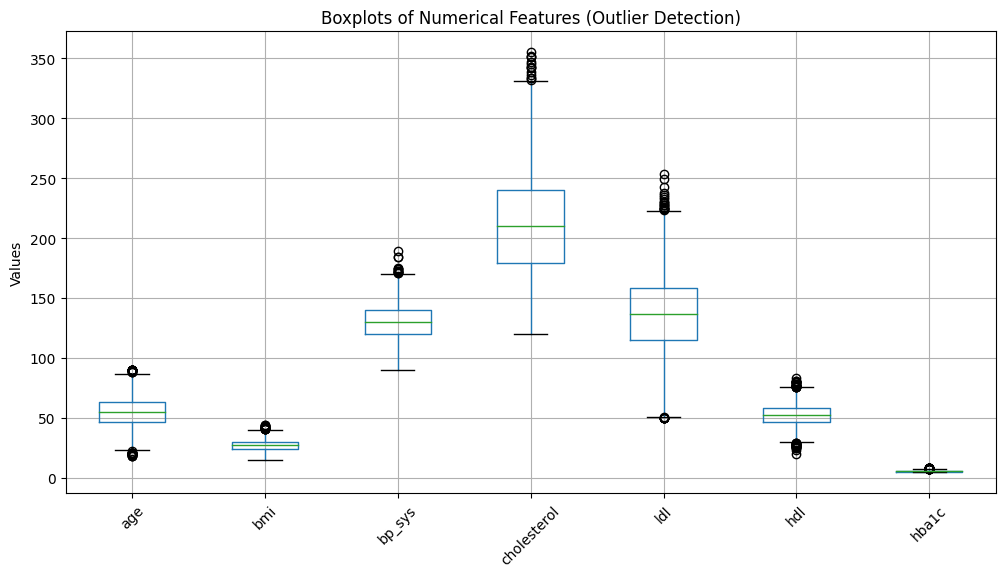

In [15]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(12, 6))
features_df[numerical_cols].boxplot()
plt.title("Boxplots of Numerical Features (Outlier Detection)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

In [16]:
# Outlier handling (capping)
def cap_outliers(df, cols, upper_percentile=0.99, lower_percentile=0.01):
    df_capped = df.copy()
    for col in cols:
        upper_bound = df_capped[col].quantile(upper_percentile)
        lower_bound = df_capped[col].quantile(lower_percentile)
        df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])
        df_capped[col] = np.where(df_capped[col] < lower_bound, lower_bound, df_capped[col])
    return df_capped

In [17]:
features_df_capped = cap_outliers(features_df, numerical_cols)
print("\nData with outliers capped:")
display(features_df_capped.describe())


Data with outliers capped:


,patient_id,age,sex,bmi,smoker,bp_sys,cholesterol,diabetes,statin_use,heart_disease,lab_id,ldl,hdl,hba1c,ever_statin
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,102499.500000,55.063600,0.53360,27.017970,0.260200,129.849700,210.261600,0.182600,0.347000,0.028800,5004.644000,136.894030,52.692740,5.618740,0.395600
std,1443.520003,11.734048,0.49892,4.858388,0.438787,14.727606,43.022931,0.386377,0.476063,0.167261,2900.182814,31.440841,8.339528,0.726507,0.489028
min,100000.000000,27.000000,0.00000,15.299000,0.000000,95.000000,120.000000,0.000000,0.000000,0.000000,2.000000,65.698000,33.100000,4.500000,0.000000
25%,101249.750000,47.000000,0.00000,23.700000,0.000000,120.000000,179.000000,0.000000,0.000000,0.000000,2499.500000,115.400000,46.800000,5.100000,0.000000
50%,102499.500000,55.000000,1.00000,27.000000,0.000000,130.000000,210.000000,0.000000,0.000000,0.000000,4997.000000,136.500000,52.600000,5.500000,0.000000
75%,103749.250000,63.000000,1.00000,30.300000,1.000000,140.000000,240.000000,0.000000,1.000000,0.000000,7554.750000,158.500000,58.300000,6.100000,1.000000
max,104999.000000,83.000000,1.00000,38.600000,1.000000,164.010000,312.000000,1.000000,1.000000,1.000000,10011.000000,212.001000,72.900000,7.500000,1.000000


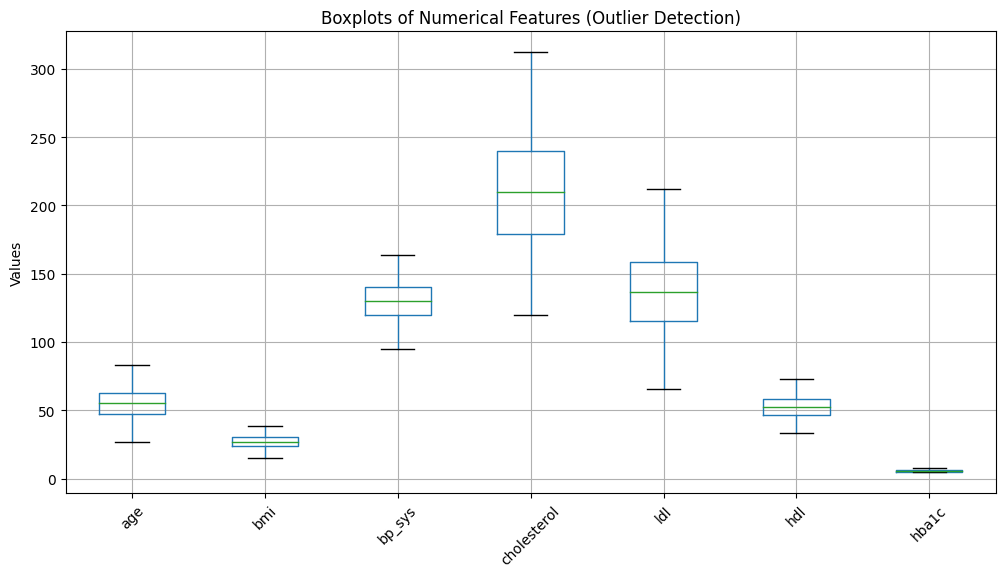

In [18]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(12, 6))
features_df_capped[numerical_cols].boxplot()
plt.title("Boxplots of Numerical Features (Outlier Detection)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()


--- EDA Plots ---


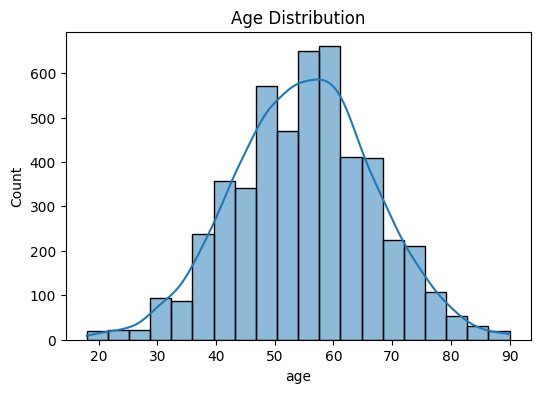

In [19]:
# Exploratory Data Analysis (EDA)
print("\n--- EDA Plots ---")
plt.figure(figsize=(6, 4))
sns.histplot(features_df['age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.show()

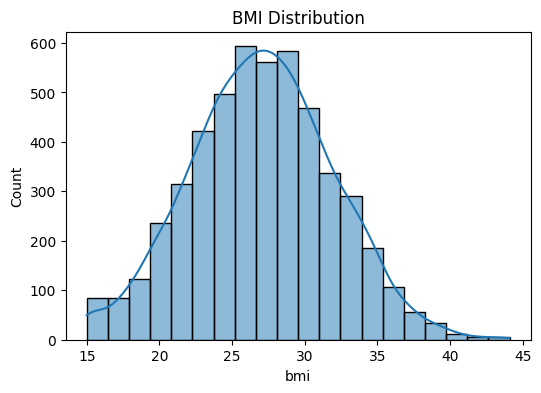

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(features_df['bmi'], kde=True, bins=20)
plt.title("BMI Distribution")
plt.show()

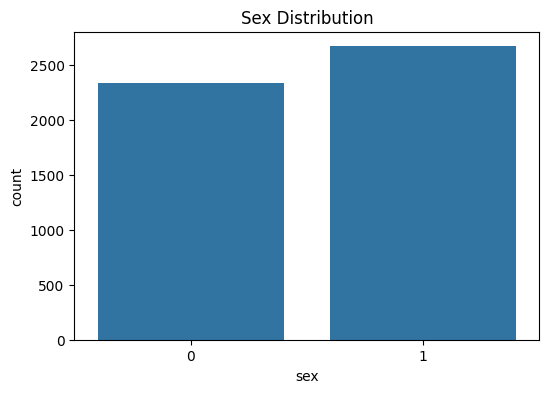

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=features_df)
plt.title("Sex Distribution")
plt.show()

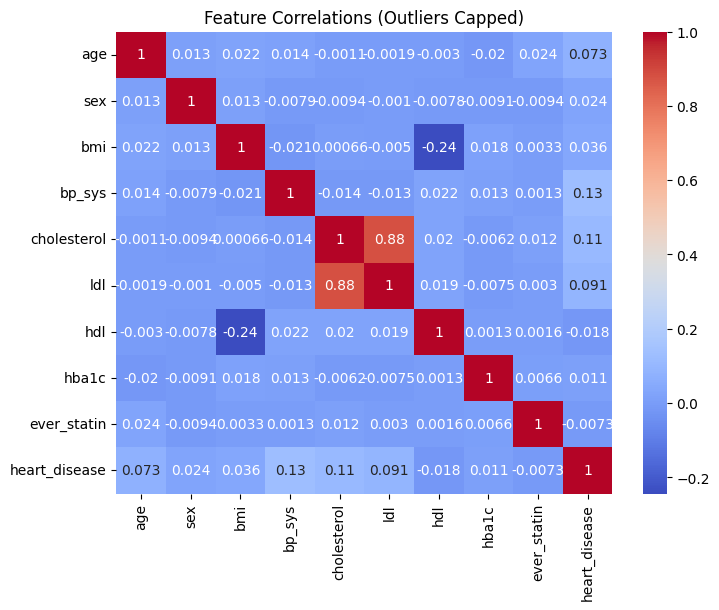

In [22]:
plt.figure(figsize=(8, 6))
corr = features_df_capped[['age', 'sex', 'bmi', 'bp_sys', 'cholesterol', 'ldl', 'hdl', 'hba1c', 'ever_statin', 'heart_disease']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlations (Outliers Capped)")
plt.show()


LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       971
           1       0.08      0.79      0.15        29

    accuracy                           0.74      1000
   macro avg       0.54      0.77      0.50      1000
weighted avg       0.97      0.74      0.83      1000

LogisticRegression Confusion Matrix:
[[717 254]
 [  6  23]]



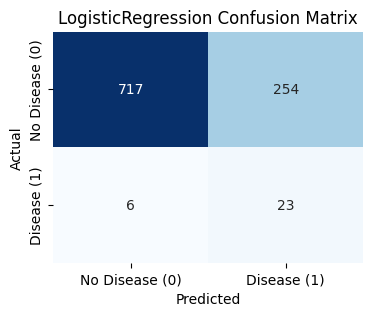


RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       971
           1       0.15      0.24      0.18        29

    accuracy                           0.94      1000
   macro avg       0.56      0.60      0.58      1000
weighted avg       0.95      0.94      0.95      1000

RandomForest Confusion Matrix:
[[931  40]
 [ 22   7]]



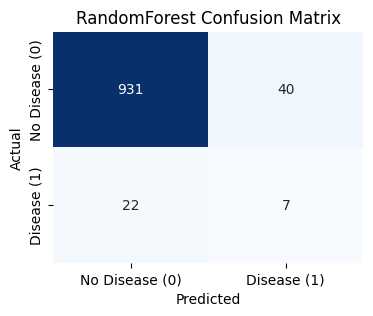


GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       971
           1       0.10      0.52      0.16        29

    accuracy                           0.85      1000
   macro avg       0.54      0.69      0.54      1000
weighted avg       0.96      0.85      0.89      1000

GradientBoosting Confusion Matrix:
[[831 140]
 [ 14  15]]



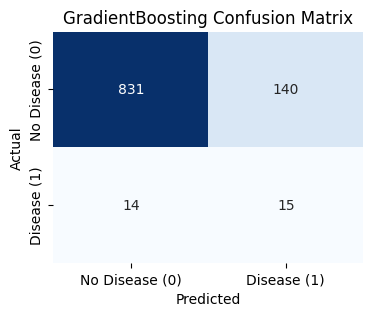

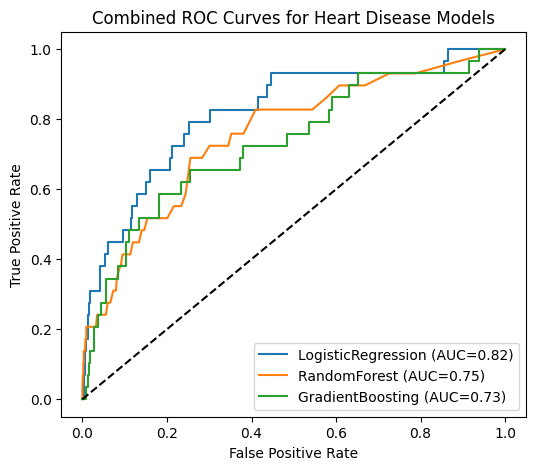

In [30]:
#  Feature Setup 
# X = features, y = target
X = features_df[['age','sex','bmi','bp_sys','cholesterol','ldl','hdl','hba1c','ever_statin']]
y = features_df['heart_disease']

#  Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#  Handle Class Imbalance 
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_s, y_train)

#  Model Setup
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train & Evaluate 
roc_scores = {}
roc_curves = {}

for name, model in models.items():
    # Train
    model.fit(X_train_bal, y_train_bal)
    # Predict probabilities
    y_proba = model.predict_proba(X_test_s)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Classification Report 
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:\n{cm}\n")

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Disease (0)", "Disease (1)"],
                yticklabels=["No Disease (0)", "Disease (1)"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Data 
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_scores[name] = roc_auc_score(y_test, y_proba)
    roc_curves[name] = (fpr, tpr)

#  Combined ROC Curve 
plt.figure(figsize=(6,5))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_scores[name]:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves for Heart Disease Models")
plt.legend()
plt.show()


--- SHAP Feature Importance ---


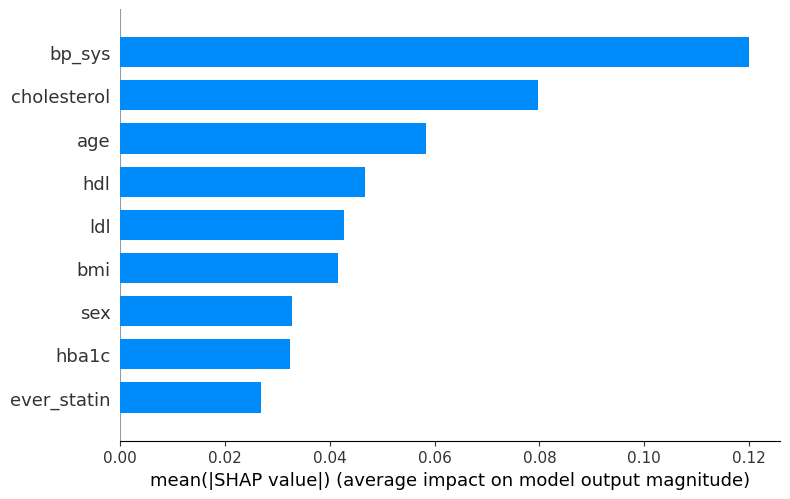

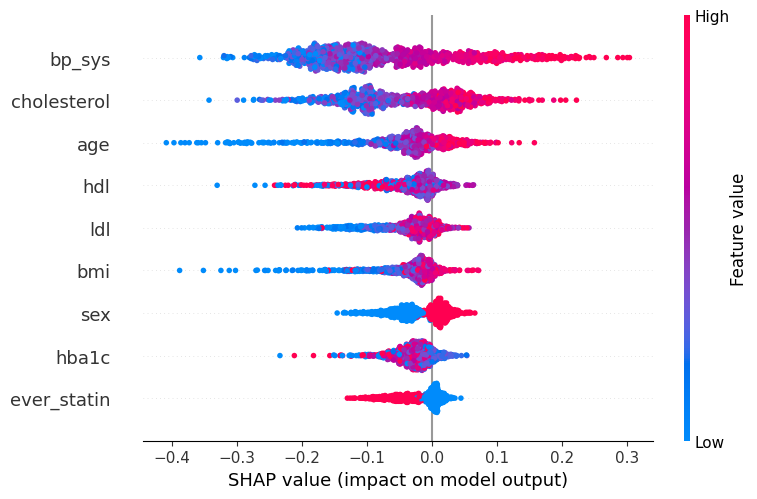

In [31]:
#SHAP
print("\n--- SHAP Feature Importance ---")
best_model = joblib.load("best_heart_disease_model.joblib")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_s)[1]
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="dot", show=True)

✅ Forecast Accuracy for ATORVASTATIN:
  RMSE: 645.86
  MAE : 522.44
  MAPE: 3.71%
✅ Forecast Accuracy for METFORMIN:
  RMSE: 1146.03
  MAE : 982.16
  MAPE: 5.63%
✅ Forecast Accuracy for ALBURX:
  RMSE: 962.62
  MAE : 814.68
  MAPE: 11.54%


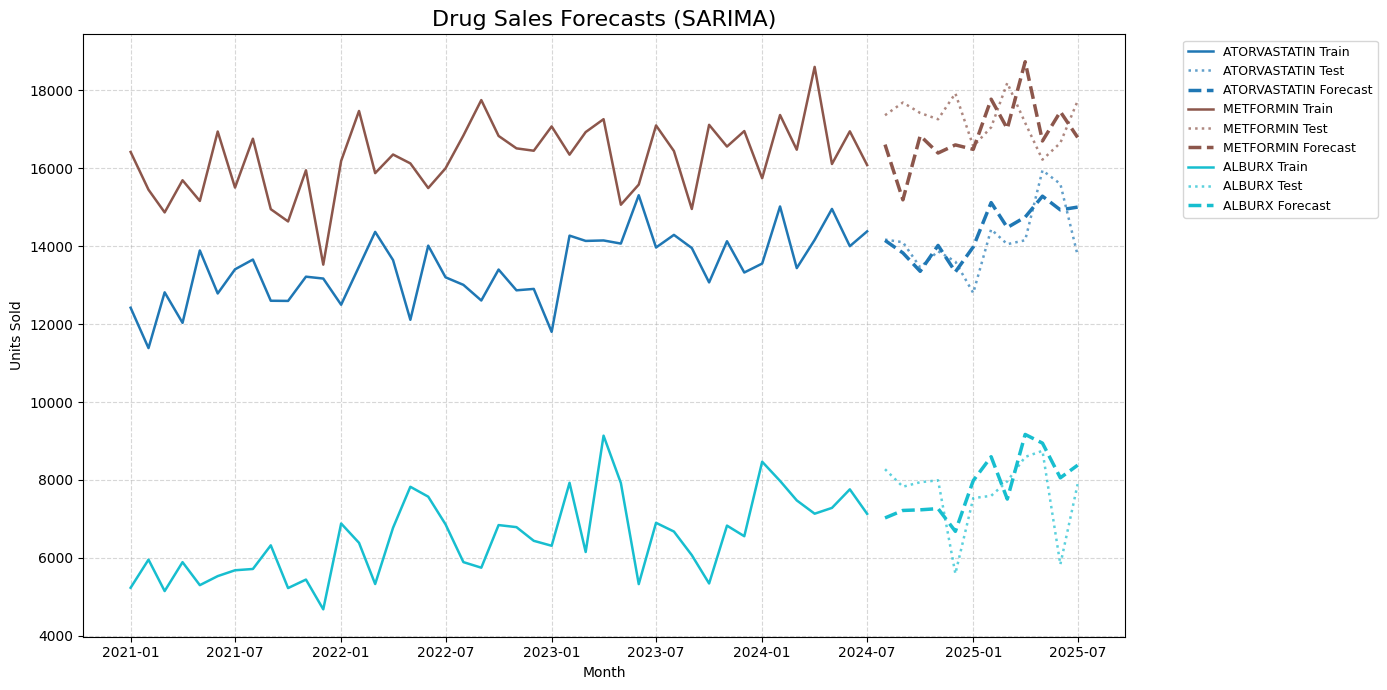

In [44]:
# SARIMA Drug Sales Forecasting 

warnings.filterwarnings("ignore")

# Data cleaning 
sales["units"] = pd.to_numeric(sales["units"], errors="coerce")
sales["month"] = pd.to_datetime(sales["month"], errors="coerce")
sales["drug"] = sales["drug"].str.upper().str.strip()


unique_drugs = sales["drug"].unique()
colors = cm.tab10(np.linspace(0, 1, len(unique_drugs))) 

plt.figure(figsize=(14, 7))


for i, drug in enumerate(unique_drugs):
    subset = sales[sales["drug"] == drug]

    # Aggregate monthly sales
    ts = (subset.groupby("month")["units"].sum()
                    .asfreq("MS")
                    .dropna())

    if len(ts) < 24:
        print(f" Skipping {drug} (need ≥ 24 months, got {len(ts)})")
        continue

    # Train-test split
    train = ts.iloc[:-12]
    test = ts.iloc[-12:]

    try:
        # Fit SARIMA model (with warnings suppressed)
        sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
        sarima_fit = sarima_model.fit(disp=False)

        # Forecast
        forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean
        forecast = forecast.reindex(test.index)

        # Align & clean
        mask = (~test.isna()) & (~forecast.isna())
        test_clean = test[mask]
        forecast_clean = forecast[mask]

        # Accuracy metrics
        if len(test_clean) > 0:
            rmse = np.sqrt(mean_squared_error(test_clean, forecast_clean))
            mae = mean_absolute_error(test_clean, forecast_clean)
            mape = np.mean(np.abs((test_clean - forecast_clean) / test_clean)) * 100

            print(f" Forecast Accuracy for {drug}:")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAE : {mae:.2f}")
            print(f"  MAPE: {mape:.2f}%")
        else:
            print(f" Could not compute metrics for {drug} (no valid test/forecast overlap)")
        base_color = colors[i % len(colors)]

        plt.plot(train.index, train, color=base_color, label=f"{drug} Train", linewidth=1.8)
        plt.plot(test.index, test, color=base_color, linestyle=":", label=f"{drug} Test", linewidth=1.8, alpha=0.7)
        plt.plot(forecast.index, forecast, color=base_color, linestyle="--", linewidth=2.5, label=f"{drug} Forecast")

    except Exception as e:
        print(f" Error forecasting {drug}: {e}")

#  Plot 
plt.title("Drug Sales Forecasts (SARIMA)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#AE NLP CLASSIFICATION

In [45]:
print("\n--- AE NLP Classification ---")
ae_df_clean = ae_reports.dropna(subset=["text", "label"]).copy()
ae_df_clean["y"] = (ae_df_clean["label"].str.lower() == "serious").astype(int)


--- AE NLP Classification ---


In [46]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(str(text).lower())
    return " ".join([lemmatizer.lemmatize(tok) for tok in tokens])
ae_df_clean["text_lemmatized"] = ae_df_clean["text"].apply(lemmatize_text)


In [47]:
X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(
    ae_df_clean["text_lemmatized"], ae_df_clean["y"], test_size=0.2, stratify=ae_df_clean["y"], random_state=42
)

In [48]:

ae_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
ae_pipe.fit(X_train_ae, y_train_ae)

y_proba_ae = ae_pipe.predict_proba(X_test_ae)[:, 1]
y_pred_ae = (y_proba_ae >= 0.5).astype(int)

In [49]:
print("Classification Report:")
print(classification_report(y_test_ae, y_pred_ae))
print("ROC-AUC:", roc_auc_score(y_test_ae, y_proba_ae))
print("F1 Score:", f1_score(y_test_ae, y_pred_ae))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       206
           1       0.80      0.95      0.87       194

    accuracy                           0.86       400
   macro avg       0.88      0.87      0.86       400
weighted avg       0.88      0.86      0.86       400

ROC-AUC: 0.8832073866479832
F1 Score: 0.8726415094339622


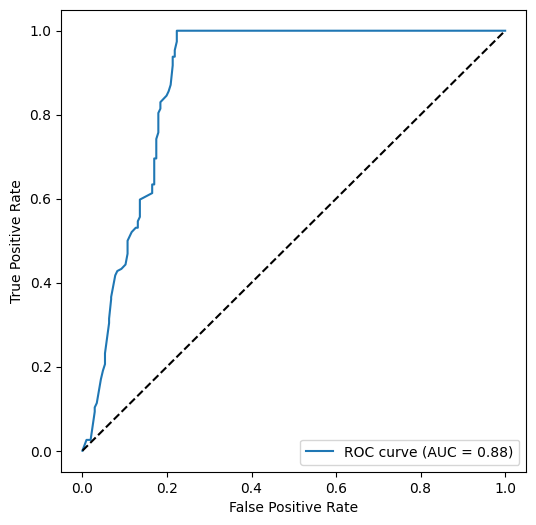

In [50]:
fpr, tpr, _ = roc_curve(y_test_ae, y_proba_ae)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

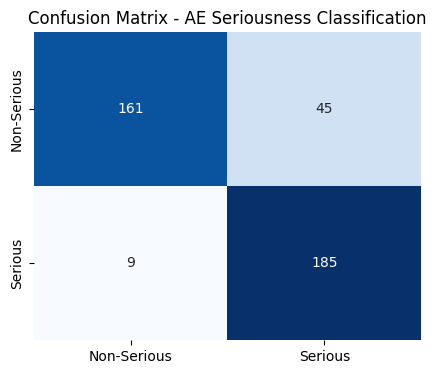

In [51]:
cm = confusion_matrix(y_test_ae, y_pred_ae)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Serious", "Serious"],
            yticklabels=["Non-Serious", "Serious"])
plt.title("Confusion Matrix - AE Seriousness Classification")
plt.show()

In [79]:
# end
conn.close()
print("\n✅ completed!")



✅ completed!
